<a href="https://colab.research.google.com/github/sujitojha1/EVA4/blob/rev5/S12/EVA4_S12_Solution_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 4, Session11 : CIFAR 10

**Target**: 


*  Write a code that draws this curve (without the arrows). In submission, you'll upload your drawn curve and code for that
    * 11s11.png 

  5. What is your test accuracy?

**Results**

*  Total Parameters = 6,573,120
*  After 24 Epochs, Final Train Accuracy = 95.75%
*  After 24 Epochs, Final Test Accuracy = 90.27%

**Analysis**

*  Target accuracy > 90% using Reset18 new architecture. Model performance is slightly overfitting.

## 1. Loading Module and Models 

In [1]:
# Load modules/models from EVA course
!rm -rf EVA4
!git clone -b rev5 https://github.com/sujitojha1/EVA4 -q --quiet
print("Loaded EVA4 Modules")

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA4 Modules


In [2]:
%%sh 
chmod u+r+x ./EVA4/S12/load_data_and_modules.sh
./EVA4/S12/load_data_and_modules.sh

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




## 2. Loading train and test data with transforms and loader functions

In [3]:
from EVA4.Modules import *

# Loading test and train data & dataloader
tiny_imagenet = dataset_tiny_imagenet(batch_size=128)

# Train dataloader
trainloader = tiny_imagenet.loader(train_flag=True)

# Test dataloader
testloader = tiny_imagenet.loader(train_flag=False)

classes = tiny_imagenet.classes

  pip install torch-lr-finder -v --global-option="amp"


CUDA availability ? True


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [0]:
#tiny_imagenet.data_summary_stats()
#print(vars(train))

### 3.2 Plotting sample images

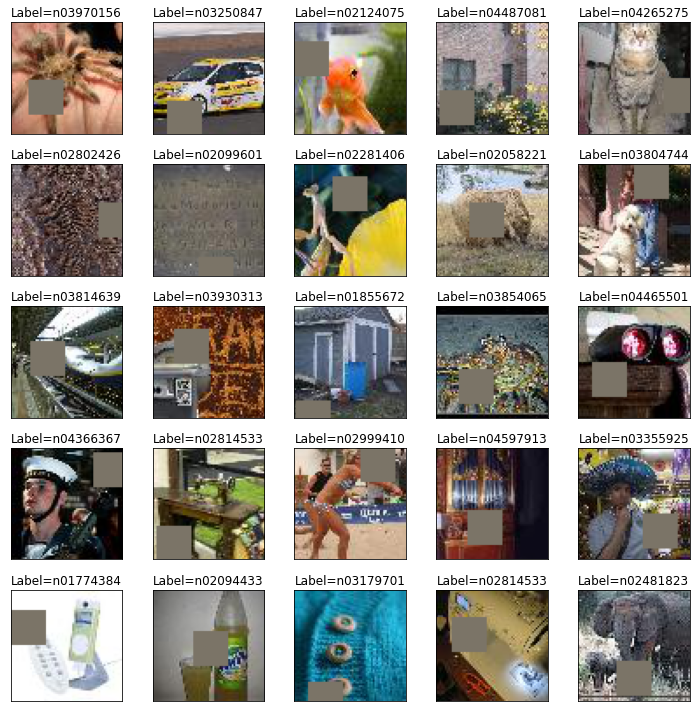

In [4]:
tiny_imagenet.sample_pictures(train_flag=True)

# The Model

In [5]:
from EVA4.Models import *

# Loading ResNet18 Model
net = ResNet_tiny_imagenet()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [6]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,728
         MaxPool2d-5          [-1, 128, 32, 32]               0
       BatchNorm2d-6          [-1, 128, 32, 32]             256
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]         147,456
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 128, 32, 32]         147,456
      BatchNorm2d-11          [-1, 128, 32, 32]             256
         ResBlock-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         294,912
        MaxPool2d-14          [-1, 256,

# Define a Loss function and optimizer

In [0]:
from EVA4.Modules import LRFinder
import torch.optim as optim

model = net
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.008) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

ValueError: ignored

In [0]:
import torch.optim as optim
model = net
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.10, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.02, 
                                          steps_per_epoch=571, 
                                          pct_start=0.20, 
                                          epochs=50,
                                          anneal_strategy='linear',
                                          base_momentum=0.8)

# Training and Testing

In [9]:
# Load train and test model
from EVA4.Modules import *

train = train()
test = test()

for epoch in range(50):  # loop over the dataset multiple times

    train.execute(net, device, trainloader, optimizer, criterion, epoch,scheduler)
    test.execute(net, device, testloader, criterion)

print('Finished Training')

  0%|          | 0/571 [00:00<?, ?it/s]


Epoch: 0


ValueError: ignored

# Misclassified images


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


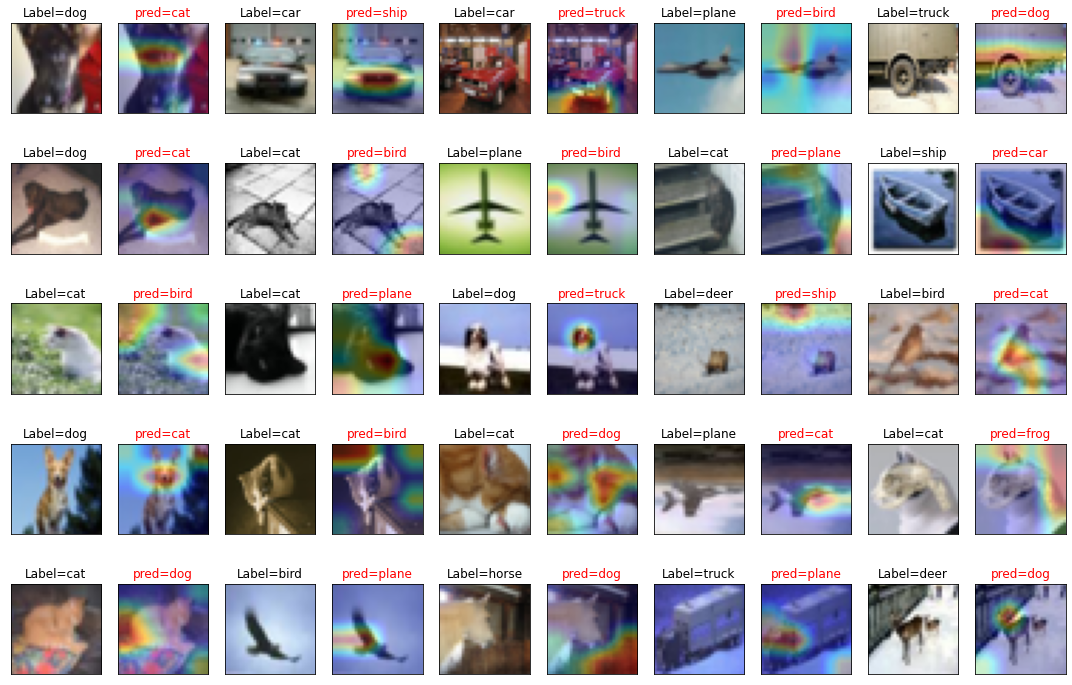

In [0]:
plot_misclassified_images_w_gradcam(net,device,testloader,classes)

# Plotting Train & Test Accuracy/Losses

# Evaluating test Accuracy over different classes 

In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 100 %
Accuracy of   car : 100 %
Accuracy of  bird : 66 %
Accuracy of   cat : 70 %
Accuracy of  deer : 85 %
Accuracy of   dog : 100 %
Accuracy of  frog : 100 %
Accuracy of horse : 92 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


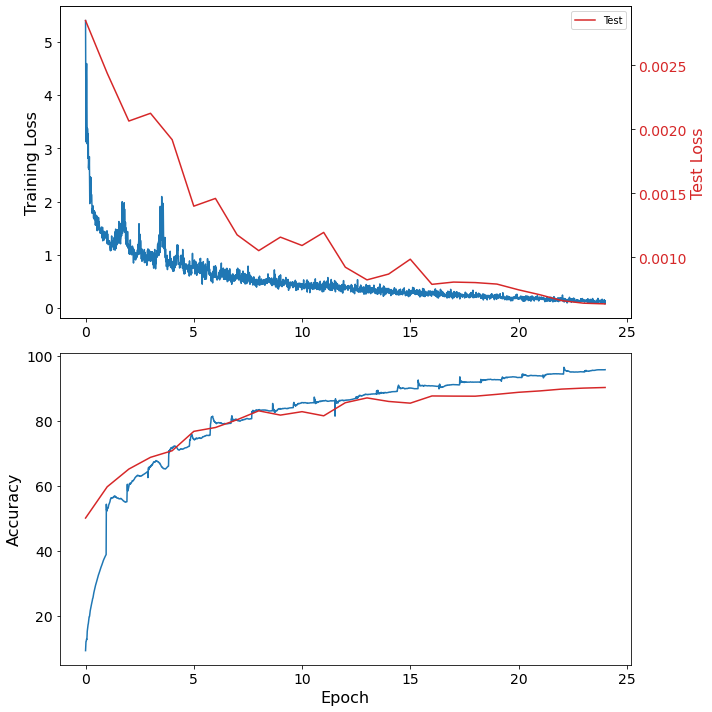

In [0]:
plot_train_test_acc_loss(train,test)